# Cities' capacity overload
---

In this notebook we calculate the estimate capacity overload day of all cities in Brazil.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc">
    <ul class="toc-item">
        <li><span><a href="#Import-packages" data-toc-modified-id="Import-packages-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import packages</a>
            </span>
        </li>
        <li><span><a href="#Model-&amp;-simulation-parameters" data-toc-modified-id="Model-&amp;-simulation-parameters-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Model &amp; simulation parameters</a>
            </span>
        </li>
        <li><span><a href="#Import-data" data-toc-modified-id="Import-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Import data</a>
            </span>
        </li>
        <li><span><a href="#Calculate-dday" data-toc-modified-id="Calculate-dday-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Calculate dday</a>
            </span>
            <ul class="toc-item">
                <li><span><a href="#Errors" data-toc-modified-id="Errors-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Errors</a>
                    </span>
                </li>
            </ul>
        </li>
        <li><span><a href="#Make-some-Maps" data-toc-modified-id="Make-some-Maps-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Maps</a>
            </span>
        </li>
    </ul>
</div>

## Import packages

In [1]:
import sys
sys.path.append("..")
sys.path.append("../src")

In [307]:
%reload_ext autoreload
%autoreload 2

from paths import RAW_PATH, TREAT_PATH, OUTPUT_PATH, FIGURES_PATH, THEMES_PATH

from copy import deepcopy
import numpy as np
import pandas as pd
pd.options.display.max_columns = 999

import warnings

warnings.filterwarnings('ignore')

# Plotting
import plotly
import plotly.graph_objs as go
import cufflinks as cf
plotly.offline.init_notebook_mode(connected=True)

# Setting cufflinks
import textwrap
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

# Centering and fixing title
def iplottitle(title, width=40):
    return '<br>'.join(textwrap.wrap(title, width))

# Adding custom colorscales (to add one: themes/custom_colorscales.yaml)
import yaml
custom_colorscales = yaml.load(open(THEMES_PATH / 'custom_colorscales.yaml', 'r'))
cf.colors._custom_scales['qual'].update(custom_colorscales)
cf.colors.reset_scales()

# Setting cuffilinks template (use it with .iplot(theme='custom')
cf.themes.THEMES['custom'] = yaml.load(open(THEMES_PATH / 'cufflinks_template.yaml', 'r'))

## Model & simulation parameters

In [3]:
config = yaml.load(open('../src/configs/config.yaml', 'r'))
config['br']['seir_parameters']

{'mild_duration': 6,
 'severe_duration': 6,
 'critical_duration': 8,
 'fatality_ratio': 0.02,
 'doubling_rate': 1.15,
 'incubation_period': 5,
 'i1_percentage': 0.855,
 'i2_percentage': 0.12,
 'i3_percentage': 0.025,
 'infected_health_care_proportion': 0.05}

In [4]:
config['simulator']

{'max_days': 90,
 'scenarios': {'worst': {'nothing': {'R0': 3.97},
   'isolation': {'R0': 1.31},
   'lockdown': {'R0': 0.37},
   'test_delay': 0},
  'best': {'nothing': {'R0': 3.74},
   'isolation': {'R0': 1.21},
   'lockdown': {'R0': 0.28},
   'test_delay': 0}}}

## Import data

In [5]:
from src.model import simulator
from src import loader

In [8]:
config

{'refresh_rate': 999999,
 'simulator': {'max_days': 90,
  'scenarios': {'worst': {'nothing': {'R0': 3.97},
    'isolation': {'R0': 1.31},
    'lockdown': {'R0': 0.37},
    'test_delay': 0},
   'best': {'nothing': {'R0': 3.74},
    'isolation': {'R0': 1.21},
    'lockdown': {'R0': 0.28},
    'test_delay': 0}}},
 'br': {'data_endpoints': {'raw': {'external': 'http://datasource.coronacidades.org:7000/v1/raw/csv',
    'local': 'http://localhost:80/v1/raw/csv'}},
  'drive_paths': {'cities_population': 'https://docs.google.com/spreadsheets/d/1k8mXuUggBuBEghHhhLrLtA-5wa4JsAc-D35S5bNlf24',
   'health_infrastructure': 'https://docs.google.com/spreadsheets/d/1JD9GREVkU_doNqQQvvA_NC18HhoulrxcJLTqxd07508',
   'embaixadores': 'https://docs.google.com/spreadsheets/d/1CASa-MdJS_o2tffWlIS--FSskSxhJUw3pA1L5AGIe04'},
  'health': {'initial_proportion': 0.2, 'source': 'SUS'},
  'cases': {'url': 'https://data.brasil.io/dataset/covid19/caso_full.csv.gz',
   'rename': {'city_ibge_code': 'city_id',
    'date'

In [11]:
config['br']['data_endpoints']['raw']['external']

'http://datasource.coronacidades.org:7000/v1/raw/csv'

In [12]:
import math
from datetime import datetime
    
def read_data(country, config, refresh_rate):

    df = pd.read_csv(config['br']['data_endpoints']['raw']['external'])
    df[[c for c in df.columns if 'last_updated' in c]] = df[[c for c in df.columns if 'last_updated' in c]].apply(pd.to_datetime)

    return  df

# health_infra = loader._download_from_drive(config['br']['drive_paths']['health_infrastructure'])
data = read_data('br', config, refresh_rate=10)

In [14]:
data

,country_iso,country_name,state_id,state_name,city_id,city_name,population,health_system_region,last_updated_number_ventilators,author_number_ventilators,number_ventilators,last_updated_number_beds,author_number_beds,number_beds,last_updated_number_icu_beds,author_number_icu_beds,number_icu_beds,last_updated,confirmed_cases,deaths,state,daily_cases,infectious_period_cases,notification_rate,active_cases,data_last_refreshed
0,BR,Brasil,AC,Acre,1200013,Acrelândia,15256,Acre,2020-02-01,SUS,NaN,2020-02-01,SUS,3.2,2020-02-01,SUS,NaN,2020-04-27,13.0,0.0,AC,1.0,2.0,1.0,2.0,2020-04-29 05:03:04
1,BR,Brasil,AC,Acre,1200054,Assis Brasil,7417,Brasiléia,2020-02-01,SUS,NaN,2020-02-01,SUS,2.4,2020-02-01,SUS,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-04-29 05:03:04
2,BR,Brasil,AC,Acre,1200104,Brasiléia,26278,Brasiléia,2020-02-01,SUS,NaN,2020-02-01,SUS,8.0,2020-02-01,SUS,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-04-29 05:03:04
3,BR,Brasil,AC,Acre,1200138,Bujari,10266,Acre,2020-02-01,SUS,NaN,2020-02-01,SUS,NaN,2020-02-01,SUS,NaN,2020-04-27,1.0,0.0,AC,0.0,0.0,1.0,0.0,2020-04-29 05:03:04
4,BR,Brasil,AC,Acre,1200179,Capixaba,11733,Acre,2020-02-01,SUS,NaN,2020-02-01,SUS,NaN,2020-02-01,SUS,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-04-29 05:03:04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5565,BR,Brasil,TO,Tocantins,1721208,Tocantinópolis,22870,Região de Saúde Portal do Bico,2020-02-01,SUS,0.6,2020-02-01,SUS,8.0,2020-02-01,SUS,NaN,2020-04-27,1.0,0.0,TO,0.0,1.0,1.0,1.0,2020-04-29 05:03:04
5566,BR,Brasil,TO,Tocantins,1721257,Tupirama,1891,Região de Saúde Cultura do Cerrado,2020-02-01,SUS,NaN,2020-02-01,SUS,NaN,2020-02-01,SUS,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-04-29 05:03:04
5567,BR,Brasil,TO,Tocantins,1721307,Tupiratins,2671,Região de Saúde de Araguaia-Tocantins,2020-02-01,SUS,NaN,2020-02-01,SUS,NaN,2020-02-01,SUS,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-04-29 05:03:04
5568,BR,Brasil,TO,Tocantins,1722081,Wanderlândia,11683,Região de Saúde Médio Norte,2020-02-01,SUS,NaN,2020-02-01,SUS,NaN,2020-02-01,SUS,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-04-29 05:03:04


## Calculate dday

In [15]:
def calculate_recovered(df, pop_params):
    """
    Calcula recuperados ajustando o total de casos com a taxa de notificação.
    """

    confirmed_adjusted = df['confirmed_cases'].sum()/df['notification_rate']
    pop_params['R'] = confirmed_adjusted - pop_params['I'] - pop_params['D']
    pop_params['R'] = pop_params['R'].fillna(0).values[0]

    if pop_params['R'] < 0:
        pop_params['R'] = confirmed_adjusted - pop_params['D']
        pop_params['R'] = pop_params['R'].fillna(0).values[0]

    return pop_params

def dday_all(city_id, supply_type='n_beds'):
    """
    Calcula dday de leitos para a cidade em cityid.
    
    supply_type (str): n_beds / n_ventilators
    """
    
    if np.isnan(city_id) == True:
        return (None, None)
    
    # Dataframe com dados historicos de casos da cidade
    df_city = data[data['city_id'] == city_id]

    if df_city['infectious_period_cases'].values[0] < 0:
        return (None, None)
    
    params = dict()
    # Parametros populacionais
    params['population'] = {
        'N': df_city['population'].values[0],
        'I': df_city['active_cases'].fillna(1).values[0],
        'D': df_city['deaths'].fillna(0).values[0]
    }
    
    # Calcula recuperados
    params['population'] = calculate_recovered(df_city, params['population'])
    
    # Parametros de capacidade hospitalar
    params['supply'] = {
        'n_beds': df_city['number_beds'].values[0],
        'n_ventilators': df_city['number_ventilators'].values[0]
    }
    
    # Parâmetros da simulação: abertura == cenário nothing por 90 dias
    params['strategy'] = {
            'isolation': 90,
            'lockdown': 90
        }
    
    # Calcula dday de [supply_type] para o municipio
    try:
        dfs = simulator.run_simulation(params['population'], params['strategy'], config)
    except Exception as e:
        print('\n\n', city_id)
        print(e)
        
    ddays = simulator.get_dday(dfs, 'I2', params['supply'][supply_type])
    return ddays['best'], ddays['worst']

In [16]:
from tqdm import tqdm, tqdm_notebook
tqdm_notebook().pandas()

In [17]:
dday_cities = pd.DataFrame({'city_id': data['city_id'].drop_duplicates()})

In [18]:
dday_cities['dday_ventilators_best'], dday_cities['dday_ventilators_worst'] = zip(*dday_cities['city_id'].progress_apply(dday_all, supply_type='n_ventilators'))

Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.


In [19]:
dday_cities['dday_beds_best'], dday_cities['dday_beds_worst'] = zip(*dday_cities['city_id'].progress_apply(dday_all, supply_type='n_beds'))

In [32]:
dday_cities

,city_id,dday_ventilators_best,dday_ventilators_worst,dday_beds_best,dday_beds_worst
0,1200013,-1,-1,23,22
1,1200054,-1,-1,26,25
2,1200104,-1,-1,33,32
3,1200138,-1,-1,-1,-1
4,1200179,-1,-1,-1,-1
...,...,...,...,...,...
5565,1721208,17,16,33,32
5566,1721257,-1,-1,-1,-1
5567,1721307,-1,-1,-1,-1
5568,1722081,-1,-1,-1,-1


In [21]:
ddays_full = data.merge(dday_cities, on='city_id')
ddays_full

,country_iso,country_name,state_id,state_name,city_id,city_name,population,health_system_region,last_updated_number_ventilators,author_number_ventilators,number_ventilators,last_updated_number_beds,author_number_beds,number_beds,last_updated_number_icu_beds,author_number_icu_beds,number_icu_beds,last_updated,confirmed_cases,deaths,state,daily_cases,infectious_period_cases,notification_rate,active_cases,data_last_refreshed,dday_ventilators_best,dday_ventilators_worst,dday_beds_best,dday_beds_worst
0,BR,Brasil,AC,Acre,1200013,Acrelândia,15256,Acre,2020-02-01,SUS,NaN,2020-02-01,SUS,3.2,2020-02-01,SUS,NaN,2020-04-27,13.0,0.0,AC,1.0,2.0,1.0,2.0,2020-04-29 05:03:04,-1,-1,23,22
1,BR,Brasil,AC,Acre,1200054,Assis Brasil,7417,Brasiléia,2020-02-01,SUS,NaN,2020-02-01,SUS,2.4,2020-02-01,SUS,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-04-29 05:03:04,-1,-1,26,25
2,BR,Brasil,AC,Acre,1200104,Brasiléia,26278,Brasiléia,2020-02-01,SUS,NaN,2020-02-01,SUS,8.0,2020-02-01,SUS,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-04-29 05:03:04,-1,-1,33,32
3,BR,Brasil,AC,Acre,1200138,Bujari,10266,Acre,2020-02-01,SUS,NaN,2020-02-01,SUS,NaN,2020-02-01,SUS,NaN,2020-04-27,1.0,0.0,AC,0.0,0.0,1.0,0.0,2020-04-29 05:03:04,-1,-1,-1,-1
4,BR,Brasil,AC,Acre,1200179,Capixaba,11733,Acre,2020-02-01,SUS,NaN,2020-02-01,SUS,NaN,2020-02-01,SUS,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-04-29 05:03:04,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5565,BR,Brasil,TO,Tocantins,1721208,Tocantinópolis,22870,Região de Saúde Portal do Bico,2020-02-01,SUS,0.6,2020-02-01,SUS,8.0,2020-02-01,SUS,NaN,2020-04-27,1.0,0.0,TO,0.0,1.0,1.0,1.0,2020-04-29 05:03:04,17,16,33,32
5566,BR,Brasil,TO,Tocantins,1721257,Tupirama,1891,Região de Saúde Cultura do Cerrado,2020-02-01,SUS,NaN,2020-02-01,SUS,NaN,2020-02-01,SUS,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-04-29 05:03:04,-1,-1,-1,-1
5567,BR,Brasil,TO,Tocantins,1721307,Tupiratins,2671,Região de Saúde de Araguaia-Tocantins,2020-02-01,SUS,NaN,2020-02-01,SUS,NaN,2020-02-01,SUS,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-04-29 05:03:04,-1,-1,-1,-1
5568,BR,Brasil,TO,Tocantins,1722081,Wanderlândia,11683,Região de Saúde Médio Norte,2020-02-01,SUS,NaN,2020-02-01,SUS,NaN,2020-02-01,SUS,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-04-29 05:03:04,-1,-1,-1,-1


In [27]:
ddays_full[ddays_full['city_name'].isin(['Manaus','Rio de Janeiro','São Paulo'])]

,country_iso,country_name,state_id,state_name,city_id,city_name,population,health_system_region,last_updated_number_ventilators,author_number_ventilators,number_ventilators,last_updated_number_beds,author_number_beds,number_beds,last_updated_number_icu_beds,author_number_icu_beds,number_icu_beds,last_updated,confirmed_cases,deaths,state,daily_cases,infectious_period_cases,notification_rate,active_cases,data_last_refreshed,dday_ventilators_best,dday_ventilators_worst,dday_beds_best,dday_beds_worst
161,BR,Brasil,AM,Amazonas,1302603,Manaus,2182763,Entorno de Manaus,2020-02-01,SUS,168.8,2020-02-01,SUS,674.4,2020-02-01,SUS,NaN,2020-04-26,2722.0,246.0,AM,44.0,1669.0,0.228293,7310.787586,2020-04-29 05:03:04,1,1,1,1
3660,BR,Brasil,RJ,Rio de Janeiro,3304557,Rio de Janeiro,6718903,Metropolitana I,2020-02-01,SUS,865.4,2020-02-01,SUS,2786.6,2020-02-01,SUS,NaN,2020-04-27,5261.0,405.0,RJ,763.0,2939.0,0.246648,11915.770956,2020-04-29 05:03:04,1,1,11,10
5348,BR,Brasil,SP,São Paulo,3550308,São Paulo,12252023,Grande São Paulo,2020-02-01,SUS,1438.6,2020-02-01,SUS,5569.4,2020-02-01,SUS,NaN,2020-04-28,15397.0,1321.0,SP,1408.0,8692.0,0.243922,35634.314019,2020-04-29 05:03:04,1,1,7,7


In [29]:
ddays_full.to_csv('data/output/cities_capacity_overload_20200429.csv')

### Errors

- Cities with negative active cases cannot go over the calculation --> is it a problem with the data or code?

In [35]:
data[data['city_id'] == 4215604]['infectious_period_cases'].values[0] < 0

True

In [31]:
data[data['infectious_period_cases'] < 0]

,country_iso,country_name,state_id,state_name,city_id,city_name,population,health_system_region,last_updated_number_ventilators,author_number_ventilators,number_ventilators,last_updated_number_beds,author_number_beds,number_beds,last_updated_number_icu_beds,author_number_icu_beds,number_icu_beds,last_updated,confirmed_cases,deaths,state,daily_cases,infectious_period_cases,notification_rate,active_cases,data_last_refreshed
657,BR,Brasil,CE,Ceará,2303303,Cariús,18699,Iguatu,2020-02-01,SUS,NaN,2020-02-01,SUS,3.2,2020-02-01,SUS,NaN,2020-04-28,1.0,1.0,CE,0.0,-1.0,0.02,-50.0,2020-04-29 05:03:04
3743,BR,Brasil,RN,Rio Grande do Norte,2405306,Januário Cicco,10181,V ETAM,2020-02-01,SUS,NaN,2020-02-01,SUS,3.6,2020-02-01,SUS,NaN,2020-04-27,0.0,0.0,RN,0.0,-1.0,1.00,-1.0,2020-04-29 05:03:04
4646,BR,Brasil,SC,Santa Catarina,4215604,Santa Rosa de Lima,2142,Tubarão,2020-02-01,SUS,NaN,2020-02-01,SUS,NaN,2020-02-01,SUS,NaN,2020-04-27,0.0,0.0,SC,0.0,-2.0,NaN,NaN,2020-04-29 05:03:04


# Make some Maps

In [282]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [325]:
## functions
def load_shapefiles():
    cities_shapefiles = gpd.read_file('../../mapas_brasil/municipios-ibge/brasil-municipios.shp')
    cities_shapefiles = cities_shapefiles.rename(columns={'CD_GEOCMU':'city_id'})[['city_id','geometry']]
    cities_shapefiles['city_id'] = cities_shapefiles['city_id'].astype(int)


    states_shapefile = gpd.read_file('../../mapas_brasil/estados-ibge/BRUFE250GC_SIR.shp')
    states_shapefile = states_shapefile.rename(columns={'NM_ESTADO':'state_name'})[['state_name','geometry']]
    states_shapefile['state_name'] = states_shapefile['state_name'].str.title().str.replace('Do','do').str.replace('De','de').str.replace('Rondônia','Rondonia')


    helth_shapefile = gpd.read_file('../../mapas_brasil/regioes_saude/regioes_saude.shp')
    helth_shapefile = helth_shapefile.rename(columns={'health_sys':'health_system_region'})[['state_id','health_system_region','geometry']]
    
    return {'cities':{'merge_col' : 'city_id'             ,
                      'col_in'      : ['city_id','city_name','state_id','state_name','health_system_region'],
                      'data'      : cities_shapefiles},
            'states':{'merge_col' : 'state_name',
                      'col_in'      : ['state_id','state_name'],
                      'data'      : states_shapefile},
            'health':{'merge_col' : ['state_id','health_system_region'],
                      'col_in'      : ['health_system_region','state_id','state_name'],
                      'data'      : helth_shapefile}
           }


def load_data():
    ddays_full = pd.read_csv('data/output/cities_capacity_overload_20200429.csv')

    cols = [
        'state_id','state_name','city_id','city_name','population','health_system_region',
        'last_updated','confirmed_cases','active_cases','deaths','daily_cases','infectious_period_cases',
        'notification_rate','dday_ventilators_best','dday_ventilators_worst','dday_beds_best','dday_beds_worst']

    return  ddays_full[cols]


def data_plus_shapefile(df, shape_files, region_type='state', region_filter=['all'], var='confirmed_cases', agg_func='sum'):
    cols = shape_files[region_type]['col_in'] + [var]
    
    dd = df[cols]
    
    if region_filter['filter_list'] == ['all']:
        pass
    else:
        dd = dd[dd[region_filter['filter_col']].isin(region_filter['filter_list'])]

    dd = dd.groupby(by=shape_files[region_type]['col_in'], as_index=False).agg(agg_func)
    dd[var] = dd[var].apply(lambda x: np.nan if x<0 else x) 

    df_plot = dd.merge(shape_files[region_type]['data'], on=shape_files[region_type]['merge_col'], how='outer')
    df_plot = gpd.GeoDataFrame(df_plot)
    
    return df_plot

In [326]:
## Load Data
shape_files = load_shapefiles()
df = load_data()

In [327]:
#prepare table
region_type = 'states'  # cities, states, health
var = 'active_cases' # variable of interest
agg_func = 'sum'       # sum, mean
region_filter = {
    'filter_list': ['all'],     #put options or 'all'
    'filter_col' : 'state_id', #col to apply the filter'
}

df_plot = data_plus_shapefile(df, shape_files, region_type, region_filter, var, agg_func)

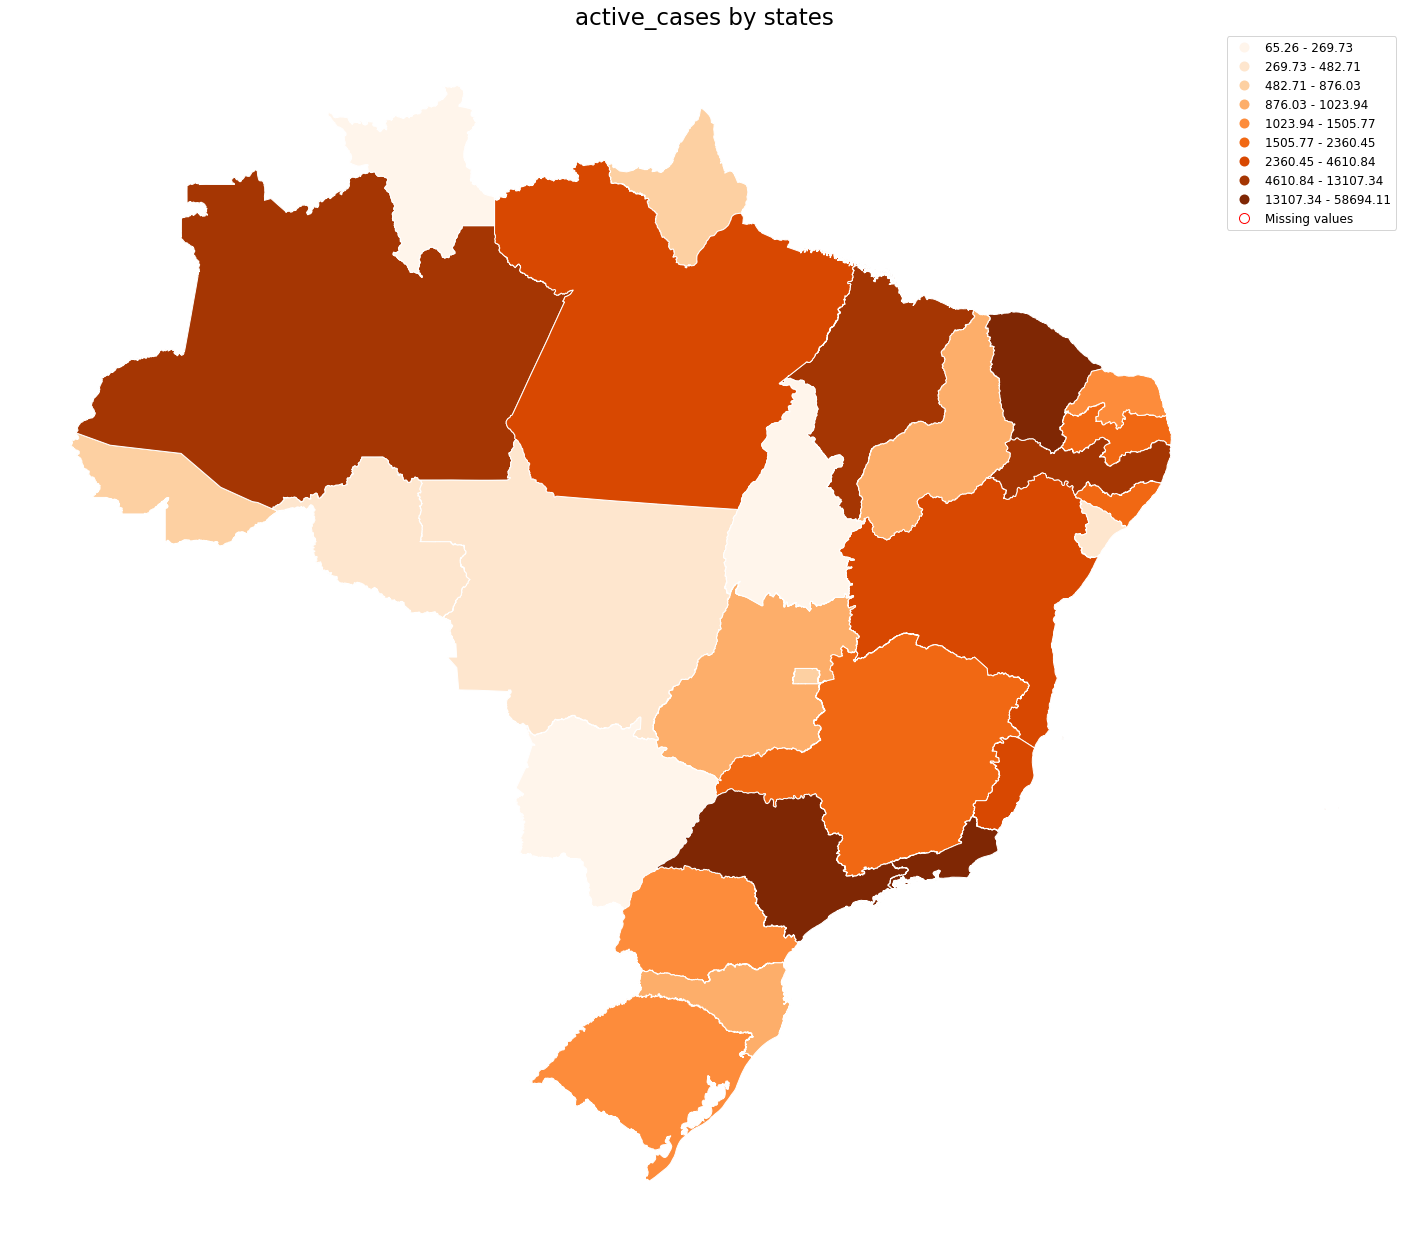

In [329]:
#Plot Map
fig = plt.figure(figsize=(25,25))
ax  = fig.add_subplot(1,1,1)
ax.set_title(f'{var} by {region_type}', fontsize=23)


missings={
    "color": "white",
    "edgecolor": "red",
    "hatch": "///",
    "label": "Missing values",
}

# df_test.plot(column=var,ax=ax, legend=True,cmap='Oranges', edgecolor = "#ffffff",  scheme='user_defined', classification_kwds={'bins':[15, 18,19,20,22,35,40,45,60]}, )
# df_plot.plot(column=var ,ax=ax, legend=True,cmap='Oranges', edgecolor = "#807158",scheme='quantiles',k=100, missing_kwds=missings
# df_plot.plot(column=var ,ax=ax, legend=True,cmap='Oranges',missing_kwds=missings, edgecolor = "#807158",scheme='user_defined',classification_kwds={'bins':scale} )

df_plot.plot(column=var ,ax=ax, legend=True,cmap='Oranges', edgecolor = "#ffffff" ,missing_kwds=missings, scheme='quantiles',k=9)
ax.axis('off')

# for idx, row in df_test.iterrows():
#     plt.annotate(s=row[var_dissolve] + "\n" + str('{:.1f}'.format(row[var])), xy=row['coords'],fontsize=18,
#                  horizontalalignment='center', color='#360102')


plt.rc('legend',fontsize='large')


In [219]:
## try to create a scale bin


all_numbers = df_plot[df_plot[var].notnull()][[var]].drop_duplicates()
all_numbers['log'] = round(np.log(all_numbers['notification_rate']))

all_numbers = all_numbers.drop_duplicates('log')
all_numbers['scale'] = np.power(10,all_numbers['log'])
scale = all_numbers.sort_values(by='scale')['scale'].tolist()